In [1]:
import xarray as xr
import numpy as np
import dask
import pandas as pd
import xwmb
import xwmt
import xgcm
import warnings
warnings.filterwarnings('ignore')
import math

import numpy as np
import regionate
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20}) 

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import cftime
from datetime import datetime
print(xwmb.__version__, xwmt.__version__, xgcm.__version__)

0.2.2 0.2.2 0.8.2.dev15+g7492277


## Makes budget plots

This notebooks makes the budget plots. Where:

- `wmt` is the WMT Budget for the MANSO region 
- `budgets` is the merged individual budget output. Two budget files can be used: a) the 7-day rolling mask approach and b) the cumulative mask approach 
- `budgets_sum` is the sum along the `mhw` dimension of all the individual events

The functions are:

- `plot_wmt_tendency_budget_rev` which plots the WMT budget tendency 
- `plot_wmt_change_budget_rev` which plots the WMT integrated budget 
- `get_deltaM`, `get_idx_max`, `get_idx_form`, `get_idx_destroy` are used the get the indices needed for the WMT integrated budget plots

In [2]:
mt_path = "/pub/mariant3/WarmWaterMasses/data/"
ocetrac_labels = xr.open_dataset(f"{mt_path}/ocetracv9/ocetrac-v9-blobs-tos-t1-r1-msq0-01860315-01891214-region.nc", chunks={'time':1})
labels = ocetrac_labels.blobs.load()

wmt = xr.open_dataset(
    f"{mt_path}WMT_data/0186-0189_wmt-daily.nc").sel(
    time=slice("0186","0189")
)

budgets = xr.open_dataset(
    f"{mt_path}budgets/7day_rolling_budgets/yearly-mhw-wmt-budgets-7d-rolling-mask_0186-0189.nc"
)

budgets_sum = budgets.sum("mhw").load()

If you want to look at the cumulative mask budgets use the path below:

```python 
budgets = xr.open_dataset(
    f"{mt_path}budgets/cumulative_mask_budgets/yearly-mhw-wmt-budgets-cumu-mask_0186-0189.nc"
)
```

In [3]:
def plot_wmt_tendency_budget_rev(wmt, thetao_l_target=29, ax=None, reverse_sign=False):
    mass_source_color = "C1"
    convergent_mass_transport_color = "C2"
    spurious_numerical_mixing_color = "C5"
    boundary_fluxes_color = "C3"
    diffusion_color = "C4"
    mass_transport_color = "sienna"  # CO
    mass_tendency_color = "C0"
    sum_color = 'gray'

    if ax is None:
        fig, ax = plt.subplots(figsize=(12,6))

    dmdt = wmt.mass_tendency.sel(thetao_l_target=thetao_l_target, method='nearest')
    Gsurf = wmt.boundary_fluxes.sel(thetao_l_target=thetao_l_target, method='nearest')
    diffusion = wmt.diffusion.sel(thetao_l_target=thetao_l_target, method='nearest')
    spur = wmt.spurious_numerical_mixing.sel(thetao_l_target=thetao_l_target, method='nearest')
    mass_source = wmt.mass_source.sel(thetao_l_target=thetao_l_target, method='nearest')
    mass_transport = wmt.convergent_mass_transport.sel(thetao_l_target=thetao_l_target, method='nearest')
    
    Gmix = diffusion + spur

    if reverse_sign:
        Gsurf = -Gsurf
        diffusion = -diffusion
        spur = -spur
        Gmix = -Gmix
        mass_source = -mass_source
        mass_transport = -mass_transport

    dmdt.plot(ax=ax, label=r"$ \mathcal{M}(\Theta)$", color=mass_tendency_color, linewidth=3, alpha=1)
    Gsurf.plot(ax=ax, label=r"$\langle \mathcal{G}^{surf} \rangle$", color=boundary_fluxes_color, linewidth=2)
    Gmix.plot(ax=ax, label=r"$\langle \mathcal{G}^{mix} \rangle$", color=diffusion_color, linewidth=2)
    mass_source.plot(ax=ax, label=r"$-\langle \mathcal{S} \rangle$", color=mass_source_color, linewidth=2)
    mass_transport.plot(ax=ax, label=r"$\Psi_{\leq}$", color=mass_transport_color, linewidth=2) 

    # ax.fill_between(wmt.time.values, dmdt, 0, where=(dmdt > 0), interpolate=True, color='lightcoral', alpha=0.3)
    
    # # Fill below 0 with blue
    # ax.fill_between(wmt.time.values, dmdt, 0, where=(dmdt < 0), interpolate=True, color='lightblue', alpha=0.3)

    ax.axhspan(0, ax.get_ylim()[1]*1e3, color='lightcoral', alpha=0.05)
    ax.axhspan(ax.get_ylim()[0]*1e3, 0, color='lightblue', alpha=0.1)


    ax.tick_params(axis='both', which='major')
    ax.tick_params(axis='both', which='minor')
    
    offset_text = ax.yaxis.get_offset_text()
    offset_text.set_color('w')
    
    months = wmt.time.dt.month.values
    years = wmt.time.dt.year.values
    
    # Find unique month-year combinations to place ticks
    unique_months = []
    tick_positions = []
    
    for i, (month, year) in enumerate(zip(months, years)):
        if i == 0 or month != months[i-1]:
            unique_months.append(f"{month:02d}-{years[0]}")
            tick_positions.append(wmt.time.values[i])
    
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(unique_months)#, rotation=45)

    ax.set_ylim(-0.6e+11, 0.6e+11)
    ax.set_xlim(wmt.time.values[0], wmt.time.values[-1])
    ax.set_title("")
    ax.set_ylabel("WWMT rate [$10^{10}$ kg/s]")
    ax.set_xlabel("")

    ax.grid(True, alpha=0.5)
    ax.legend(loc='lower left')

    if ax is None:
        plt.tight_layout()
        plt.show()

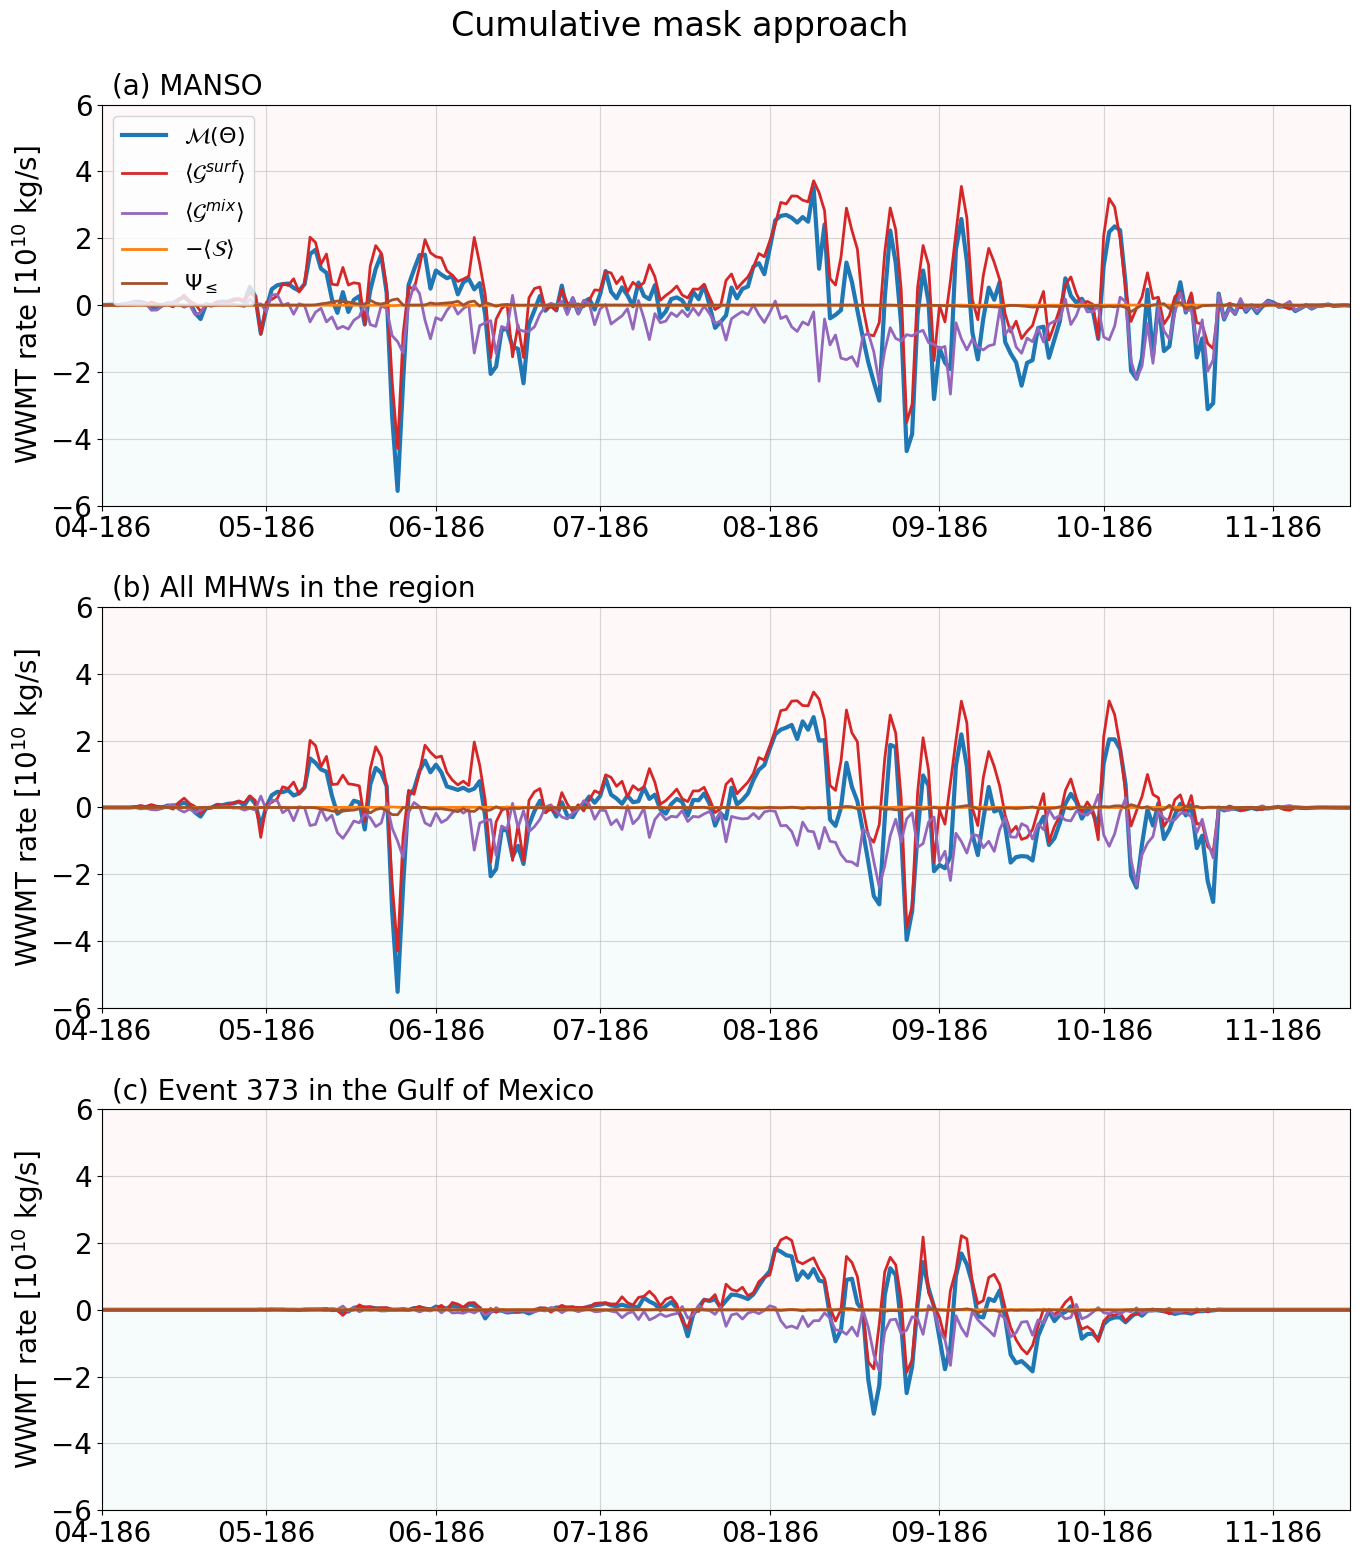

In [4]:
t1 = "0186-04"
t2 = "0186-11-15"
id = 373

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 16))
plt.subplots_adjust(hspace=0.1)

plot_wmt_tendency_budget_rev(wmt.sel(time=slice(t1,t2)),reverse_sign=True, ax=ax1)
ax1.text(0.008, 1.08, '(a) MANSO', transform=ax1.transAxes, va='top')
plt.tight_layout()

plot_wmt_tendency_budget_rev(budgets_sum.sel(time=slice(t1,t2)), ax=ax2)
ax2.text(0.008, 1.08, '(b) All MHWs in the region', transform=ax2.transAxes, va='top') # 1.055
ax2.legend().remove()
plt.tight_layout()

plot_wmt_tendency_budget_rev(budgets.sel(mhw=id).sel(time=slice(t1,t2)), ax=ax3)
ax3.text(0.008, 1.08, '(c) Event 373 in the Gulf of Mexico', transform=ax3.transAxes, va='top')
ax1.legend(loc='upper left', frameon=True, fontsize = 16)
ax3.legend().remove()

plt.suptitle("Cumulative mask approach")
plt.tight_layout()
# plt.savefig(f"../figures/tendency-term-budgets_20_cumu.png",dpi=350,bbox_inches="tight")

plt.show()

In [5]:
def get_deltaM(ds, thetao_l_target=29):
    s = 86400
    deltaM = (ds.mass_tendency * s).cumsum('time').sel(thetao_l_target=thetao_l_target, method='nearest')
    return deltaM

def get_idx_max(ds, thetao_l_target=29):
    deltaM = get_deltaM(ds, thetao_l_target)
    return int(deltaM.argmax().values)

def get_idx_form(ds, thetao_l_target=29):
    idx_max = get_idx_max(ds, thetao_l_target)
    return np.arange(0, idx_max + 1)

def get_idx_destroy(ds, thetao_l_target=29):
    idx_max = get_idx_max(ds, thetao_l_target)
    return np.arange(idx_max, ds.time.size)

In [6]:
def plot_wmt_change_budget_rev(wmt, delta_M, idx_max, idx_form, idx_destroy, thetao_l_target=29, ax=None, reverse_sign=False):

    mass_source_color = "C1"
    boundary_fluxes_color = "C3"
    diffusion_color = "C4"
    mass_transport_color = "sienna"
    mass_tendency_color = "C0"
    sum_color = 'gray'
    plt.rcParams.update({'font.size': 20}) 
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,6))
    
    s = 86400
    
    dmdt = (wmt.mass_tendency * s).cumsum('time').sel(thetao_l_target=thetao_l_target, method='nearest')
    dmdt.plot(ax=ax, label=r"$\mathcal{M}(\Theta)$", color=mass_tendency_color, linewidth=3, alpha=1)
    
    Gsurf = (wmt.boundary_fluxes * s).cumsum('time').sel(thetao_l_target=thetao_l_target, method='nearest')
    if reverse_sign:
        Gsurf = -Gsurf
    Gsurf.plot(ax=ax, label=r"$\langle \mathcal{G}^{surf} \rangle$", color=boundary_fluxes_color, linewidth=2)
    
    diffusion = (wmt.diffusion * s).cumsum('time').sel(thetao_l_target=thetao_l_target, method='nearest')
    spur = (wmt.spurious_numerical_mixing * s).cumsum('time').sel(thetao_l_target=thetao_l_target, method='nearest')
    mass_source = (wmt.mass_source * s).cumsum('time').sel(thetao_l_target=thetao_l_target, method='nearest')
    mass_transport = (wmt.convergent_mass_transport * s).cumsum('time').sel(thetao_l_target=thetao_l_target, method='nearest')
    
    if reverse_sign:
        diffusion = -diffusion
        spur = -spur
    Gmix = diffusion + spur
    Gmix.plot(ax=ax, label=r"$\langle \mathcal{G}^{mix} \rangle$", color=diffusion_color, linewidth=2)
    
    mass_source.plot(ax=ax, label=r"$-\langle \mathcal{S} \rangle$", color=mass_source_color, linewidth=2)
    mass_transport.plot(ax=ax, label=r"$\Psi_{\leq}$", color=mass_transport_color, linewidth=2)
    
    all_terms = Gsurf + Gmix + mass_source + mass_transport
    all_terms.plot(ax=ax, label=r"$\langle \mathcal{G}^{surf}+\mathcal{G}^{mix} \rangle$", color=sum_color, linestyle="--", linewidth=1.5)
    
    # Mark the maximum point on the cumulative curve
    marker_value = delta_M.isel(time=idx_max)
    ax.plot(delta_M.time.isel(time=idx_max), marker_value, 'wo', markersize=8, markeredgecolor='k', 
            label=r"$\max\,\mathcal{M}(\Theta)$")
    
    ax.axhline(0, color='black', linestyle='-', linewidth=1)
    
    # Fill formation phase (from start to max)
    # fill_times_form = delta_M.time.isel(time=slice(0, idx_max+1)).values
    # fill_deltaM_form = delta_M.isel(time=slice(0, idx_max+1)).values
    # mass_source_limit_form = (wmt['mass_source'] * wmt.dt).cumsum('time').interp(thetao_l_target=thetao_l_target).isel(time=slice(0, idx_max+1)).values
    # # ax.fill_between(fill_times_form, hline, fill_deltaM_form, color='r', alpha=0.2)
    # ax.fill_between(fill_times_form, mass_source_limit_form, fill_deltaM_form, color='r', alpha=0.2)

    fill_times_form = dmdt.time.isel(time=slice(0, idx_max+1)).values
    fill_dmdt_form = dmdt.isel(time=slice(0, idx_max+1)).values
    ax.fill_between(fill_times_form, 0, fill_dmdt_form, color='r', alpha=0.2)
    
    # Fill destruction phase (from max to the end using idx_destroy[-1])

    fill_times_des = dmdt.time.isel(time=slice(idx_max, dmdt.time.size)).values
    fill_dmdt_des = dmdt.isel(time=slice(idx_max, dmdt.time.size)).values
    ax.fill_between(fill_times_des, 0, fill_dmdt_des, color="#48a0f8", alpha=0.3)


    # fill_times_des = delta_M.time.isel(time=slice(idx_max, idx_destroy[-1])).values
    # fill_deltaM_des = delta_M.isel(time=slice(idx_max, idx_destroy[-1])).values
    # mass_source_limit_des = (wmt['mass_source'] * wmt.dt).cumsum('time').interp(thetao_l_target=thetao_l_target).isel(time=slice(idx_max, idx_destroy[-1])).values
    # ax.fill_between(fill_times_des, mass_source_limit_des, fill_deltaM_des, color="#48a0f8", alpha=0.3)
    
    ax.tick_params(axis='both', which='major')
    ax.tick_params(axis='both', which='minor')
    
    offset_text = ax.yaxis.get_offset_text()
    offset_text.set_color('w')
    
    # Set x-axis ticks with unique month-year labels
    months = wmt.time.dt.month.values
    years = wmt.time.dt.year.values
    unique_labels = []
    tick_positions = []
    for i, (month, year) in enumerate(zip(months, years)):
        if i == 0 or month != months[i-1]:
            unique_labels.append(f"{month:02d}-{year}")
            tick_positions.append(wmt.time.values[i])
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(unique_labels)
    
    ax.set_ylim(-0.095e+18, 0.095e+18)
    ax.set_xlim(wmt.time.values[0], wmt.time.values[-1])
    ax.set_title("")
    ax.set_ylabel("Integrated warm water mass budget \n[$10^{16}$ kg]")
    ax.set_xlabel("")
    
    ax.grid(True, alpha=0.5)
    ax.legend(loc='lower left')
    plt.tight_layout()
    if ax is None:
        plt.show()


In [7]:
t1 = "0189-04"
t2 = "0189-11-15"
thetao_target = 29
budget = budgets.sel(mhw=5987).sel(time=slice(t1, t2))

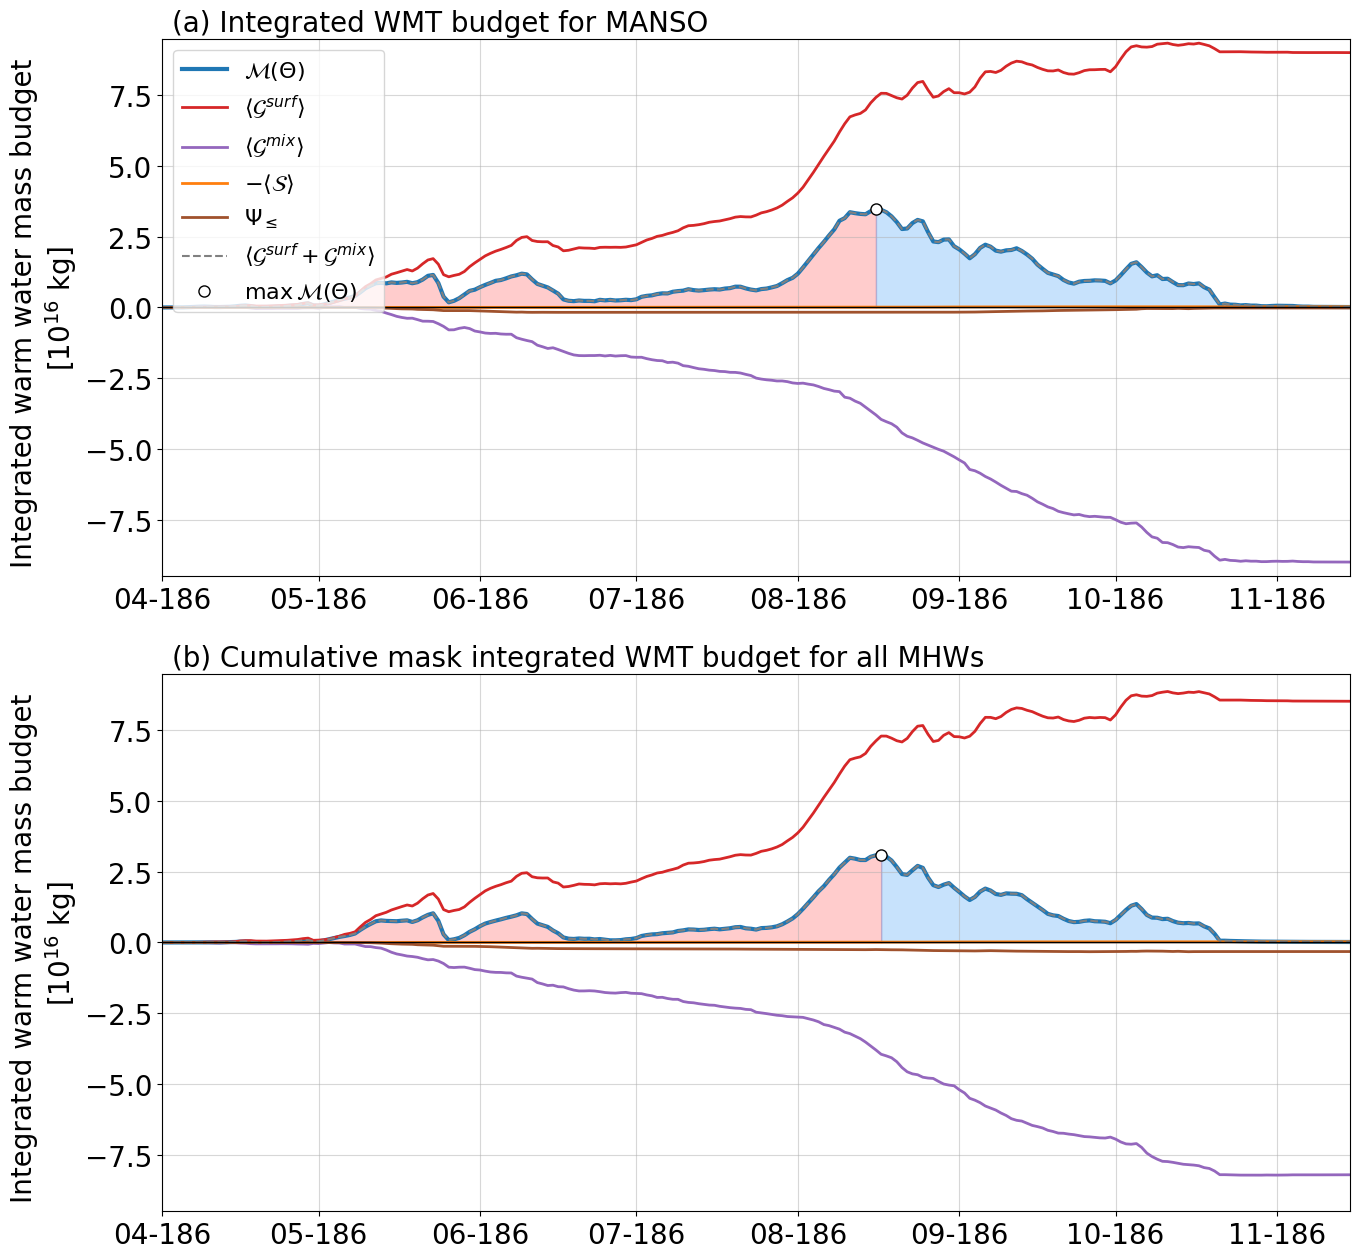

In [8]:
# Plot only 2 WMT integrated budgets (MANSO and all MHWs)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 13))
plt.subplots_adjust(hspace=0.1)

thetao_target = 29
wmt = wmt.sel(time=slice("0186-04", "0186-11-15"))
budgets_sum = budgets_sum.sel(time=slice("0186-04", "0186-11-15"))

plot_wmt_change_budget_rev(
    wmt=wmt,
    delta_M=get_deltaM(wmt, thetao_target),
    idx_max=get_idx_max(wmt, thetao_target),
    idx_form=get_idx_form(wmt, thetao_target),
    idx_destroy=get_idx_destroy(wmt, thetao_target),
    thetao_l_target=thetao_target,
    ax=ax1,
    reverse_sign=True
)
ax1.text(0.008, 1.055, '(a) Integrated WMT budget for MANSO', transform=ax1.transAxes, va='top')
ax1.legend(loc='upper left', frameon=True, fontsize=16)
ax1.set_ylim(-0.095e+18, 0.095e+18)

plot_wmt_change_budget_rev(
    wmt=budgets_sum,
    delta_M=get_deltaM(budgets_sum, thetao_target),
    idx_max=get_idx_max(budgets_sum, thetao_target),
    idx_form=get_idx_form(budgets_sum, thetao_target),
    idx_destroy=get_idx_destroy(budgets_sum, thetao_target),
    thetao_l_target=thetao_target,
    ax=ax2,
    reverse_sign=False
)
ax2.text(0.008, 1.055, '(b) Cumulative mask integrated WMT budget for all MHWs', transform=ax2.transAxes, va='top')
ax2.legend().remove()
# ax2.set_ylim(-0.011e+19, 0.011e+19)
ax2.set_ylabel("Integrated warm water mass budget \n[$10^{16}$ kg]")

plt.tight_layout()
# plt.savefig(f"../figures/panel-2_integrated-budgets_cumu_norm.png",dpi=350,bbox_inches="tight")

plt.show()

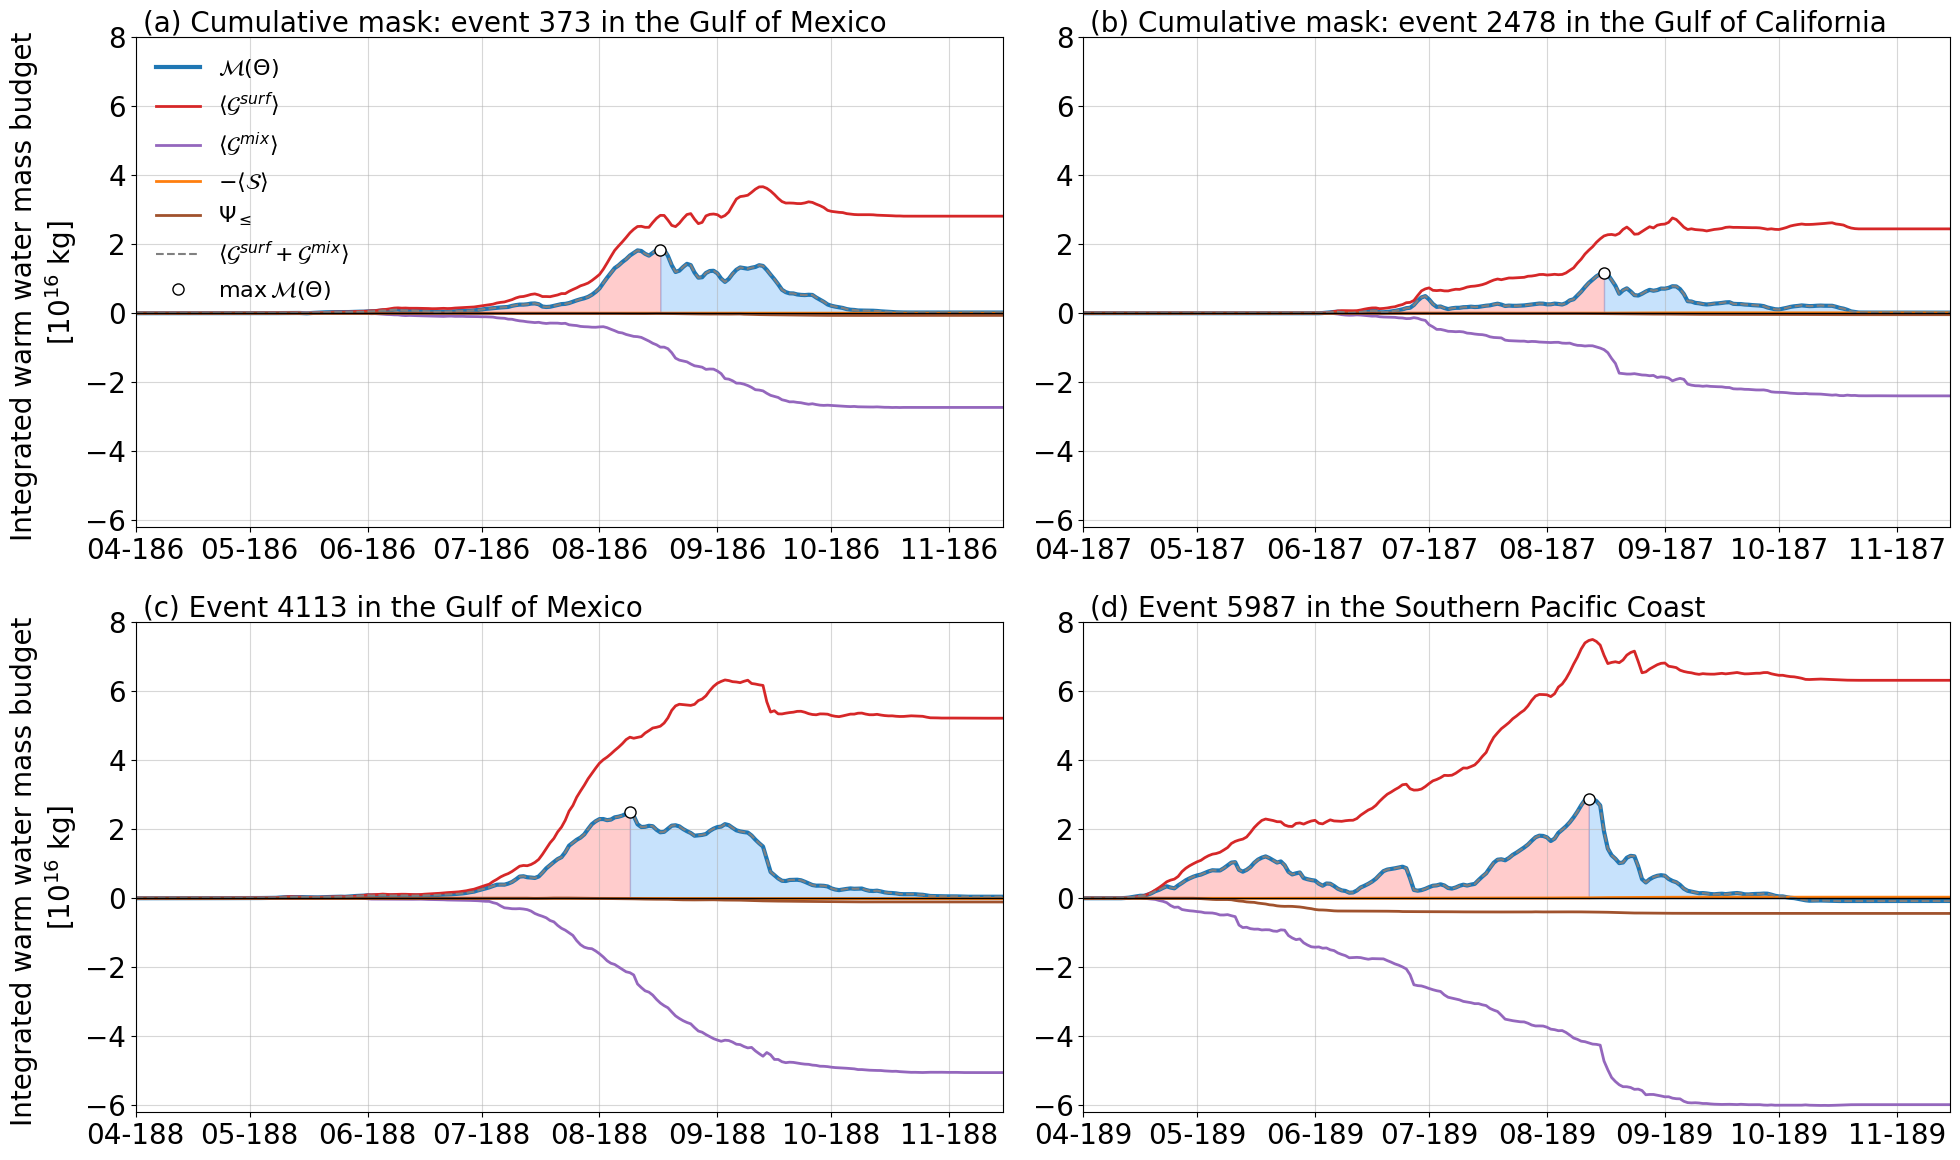

In [9]:
# Plot only the 4 events

thetao_target = 29

a, b, c, d = 373, 2478, 4113, 5987
loc = {a: 'Gulf of Mexico', b: 'Gulf of California', c: 'Southern Pacific Coast'}

budget_a = budgets.sel(mhw=a).sel(time=slice("0186-04", "0186-11-15"))
budget_b = budgets.sel(mhw=b).sel(time=slice("0187-04", "0187-11-15")) # 2478 2253 (2478 de baja a puerto)
budget_c = budgets.sel(mhw=c).sel(time=slice("0188-04", "0188-11-15")) # puerto # 4113
budget_d = budgets.sel(mhw=d).sel(time=slice("0189-04", "0189-11-15")) #  5987 6070

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
plt.subplots_adjust(hspace=0.1)

# Panel (a)
plot_wmt_change_budget_rev(
    wmt=budget_a,
    delta_M=get_deltaM(budget_a, thetao_target),
    idx_max=get_idx_max(budget_a, thetao_target),
    idx_form=get_idx_form(budget_a, thetao_target),
    idx_destroy=get_idx_destroy(budget_a, thetao_target),
    thetao_l_target=thetao_target,
    ax=ax1,
    reverse_sign=False
)
ax1.text(0.008, 1.055, f'(a) Cumulative mask: event {a} in the {loc[a]}', transform=ax1.transAxes, va='top')
ax1.legend(loc='upper left', frameon=False, fontsize=16)
# ax1.set_ylim(-0.3e+17, 0.4e+17)
ax1.set_ylim(-0.62e+17, 0.8e+17)

# Panel (b)
plot_wmt_change_budget_rev(
    wmt=budget_b,
    delta_M=get_deltaM(budget_b, thetao_target),
    idx_max=get_idx_max(budget_b, thetao_target),
    idx_form=get_idx_form(budget_b, thetao_target),
    idx_destroy=get_idx_destroy(budget_b, thetao_target),
    thetao_l_target=thetao_target,
    ax=ax2,
    reverse_sign=False
)
ax2.text(0.008, 1.055, f'(b) Cumulative mask: event {b} in the {loc[b]}', transform=ax2.transAxes, va='top')
ax2.legend().remove()
ax2.set_ylabel("")
# ax2.set_ylim(-0.25e+17, 0.3e+17)
ax2.set_ylim(-0.62e+17, 0.8e+17)

# Panel (c)
plot_wmt_change_budget_rev(
    wmt=budget_c,
    delta_M=get_deltaM(budget_c, thetao_target),
    idx_max=get_idx_max(budget_c, thetao_target),
    idx_form=get_idx_form(budget_c, thetao_target),
    idx_destroy=get_idx_destroy(budget_c, thetao_target),
    thetao_l_target=thetao_target,
    ax=ax3,
    reverse_sign=False
)
ax3.text(0.008, 1.055, f'(c) Event {c} in the {loc[a]}', transform=ax3.transAxes, va='top')
ax3.legend().remove()
# ax3.set_ylim(-0.53e+17, 0.64e+17)
ax3.set_ylim(-0.62e+17, 0.8e+17)
# Panel (d)
plot_wmt_change_budget_rev(
    wmt=budget_d,
    delta_M=get_deltaM(budget_d, thetao_target),
    idx_max=get_idx_max(budget_d, thetao_target),
    idx_form=get_idx_form(budget_d, thetao_target),
    idx_destroy=get_idx_destroy(budget_d, thetao_target),
    thetao_l_target=thetao_target,
    ax=ax4,
    reverse_sign=False
)
ax4.text(0.008, 1.055, f'(d) Event {d} in the {loc[c]}', transform=ax4.transAxes, va='top')
ax4.legend().remove()
# ax4.set_ylim(-0.1e+16, 0.1e+16)
ax4.set_ylabel("")
ax4.set_ylim(-0.62e+17, 0.8e+17)

plt.tight_layout()
# plt.savefig(f"../figures/mass_change_budgets_4_events.png",dpi=350,bbox_inches="tight")
plt.show()

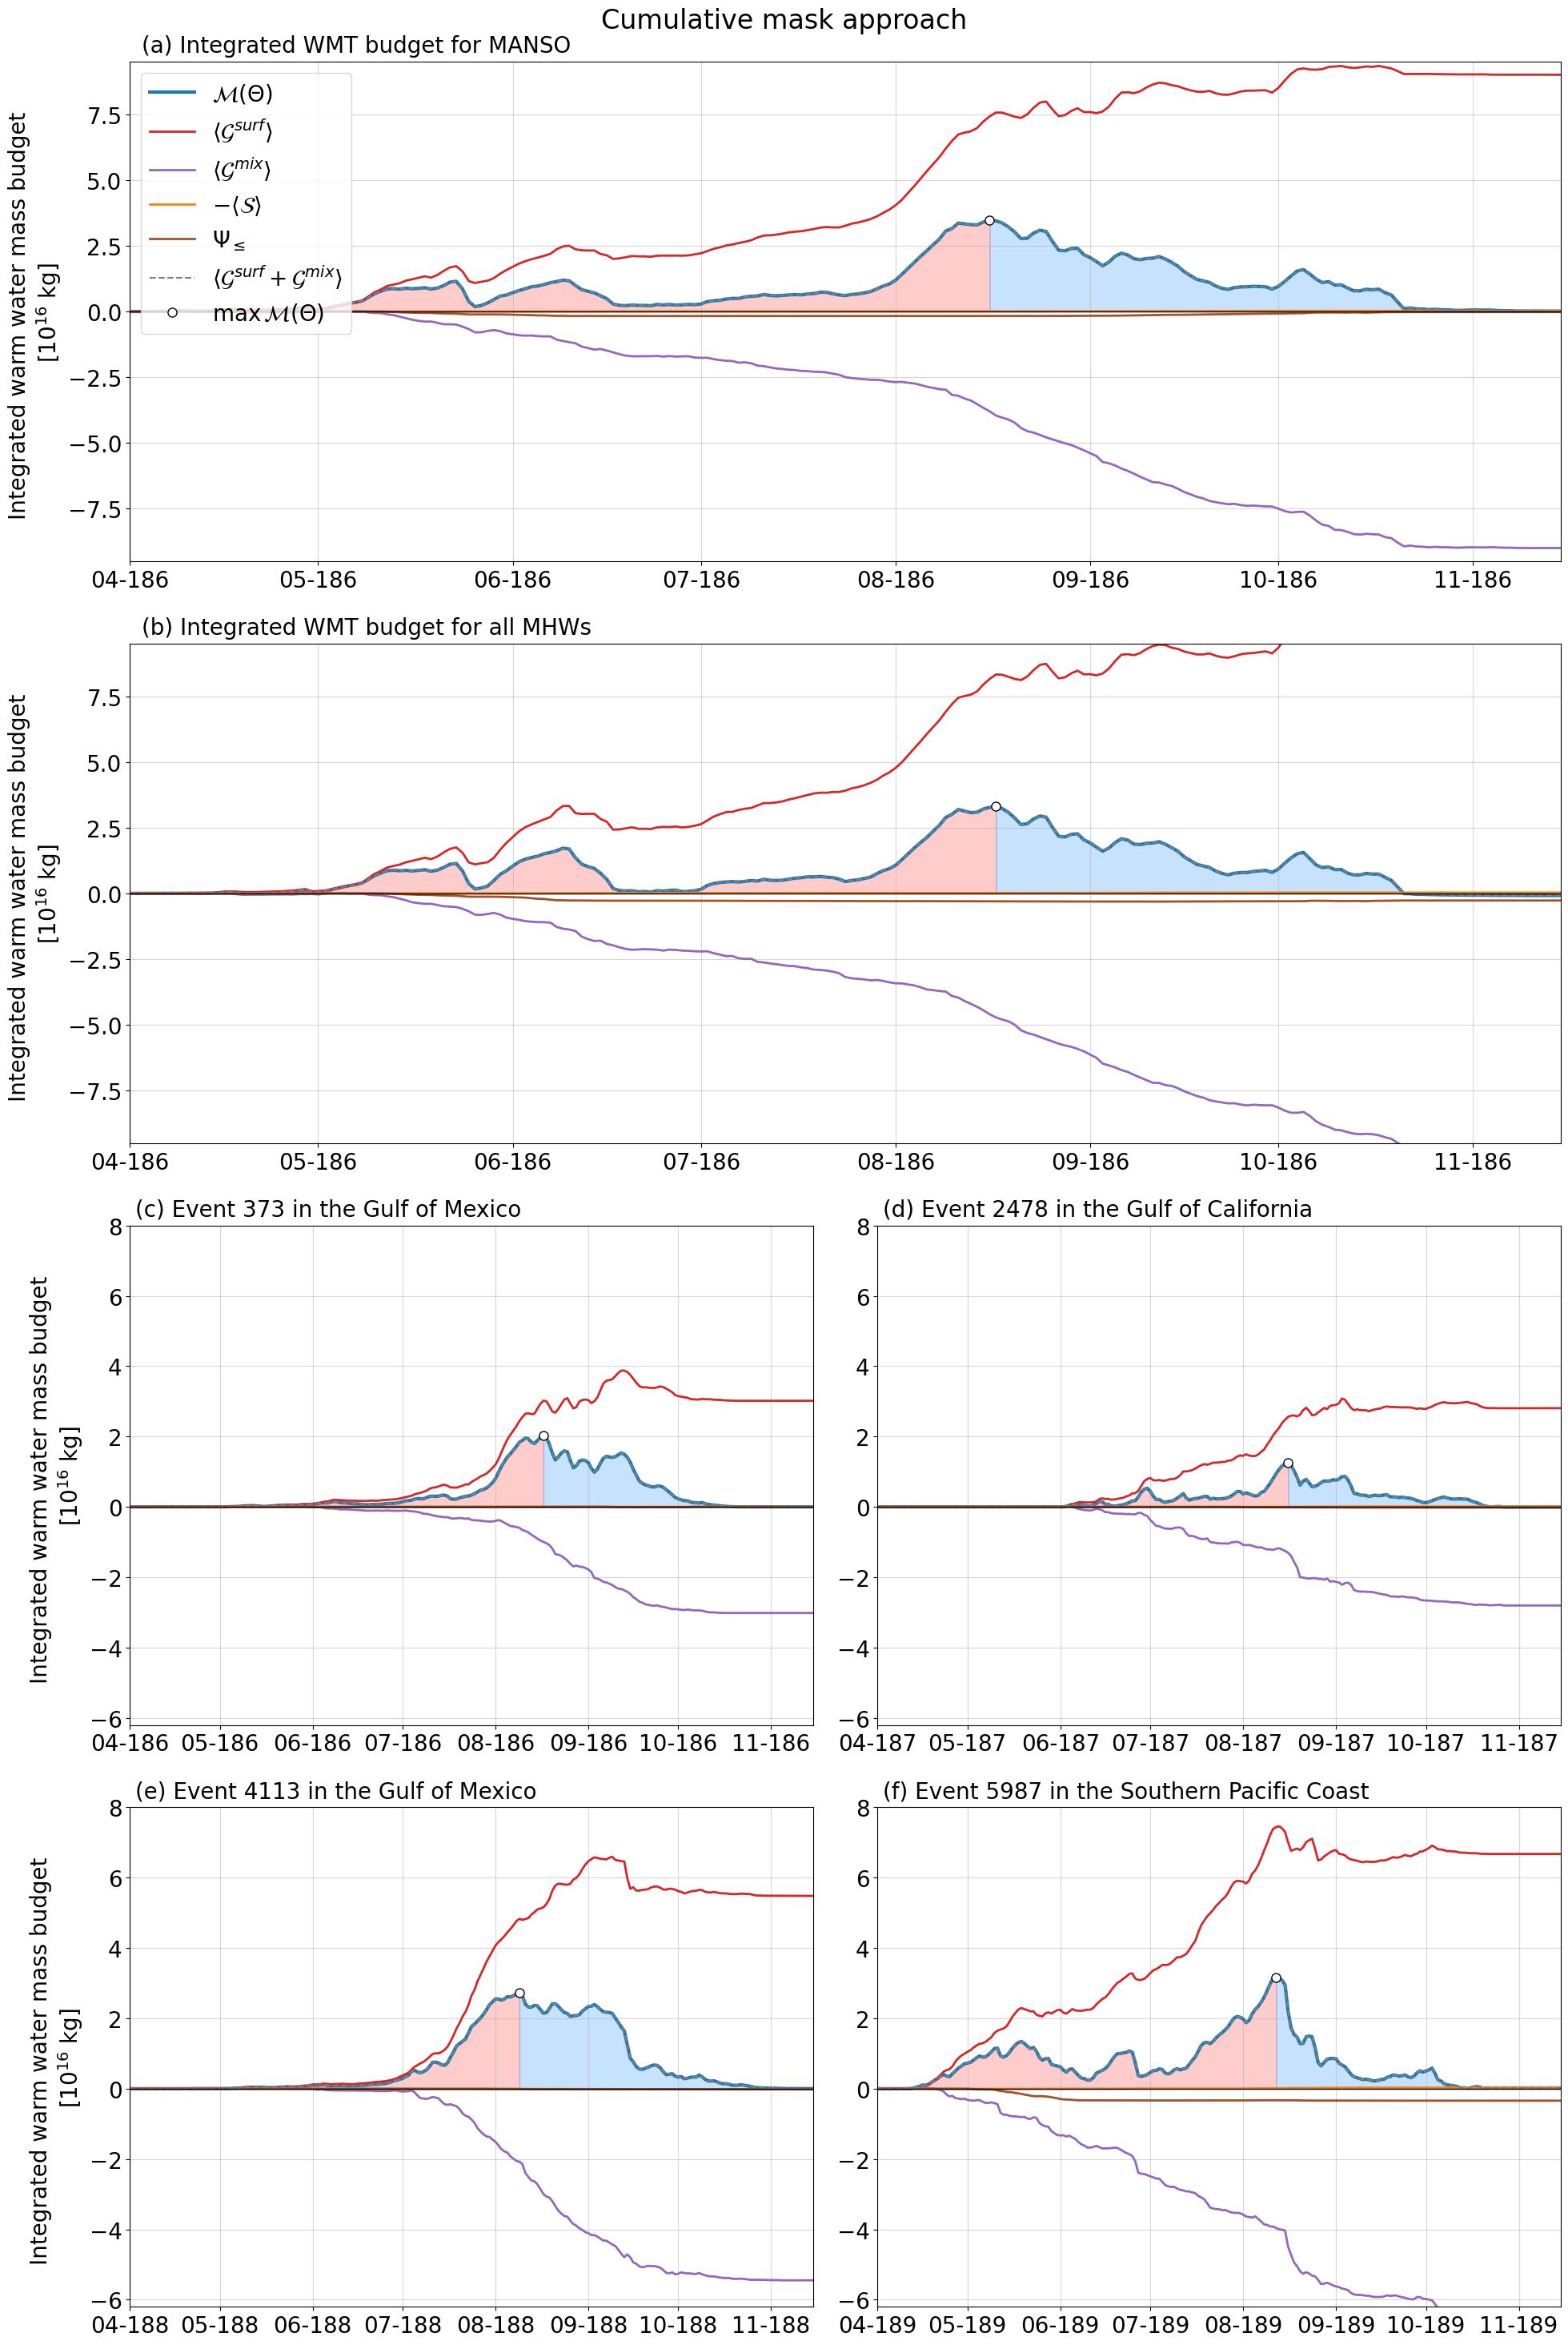

In [57]:
# Huge figure with all the WMT integrated budgets

thetao_target = 29

wmt_manso = wmt.sel(time=slice("0186-04", "0186-11-15"))
budgets_sum_mhw = budgets_sum.sel(time=slice("0186-04", "0186-11-15"))

a, b, c, d = 373, 2478, 4113, 5987
loc = {
    a: 'Gulf of Mexico',
    b: 'Gulf of California',
    c: 'Southern Pacific Coast',
}

budget_a = budgets.sel(mhw=a).sel(time=slice("0186-04","0186-11-15"))
budget_b = budgets.sel(mhw=b).sel(time=slice("0187-04","0187-11-15"))
budget_c = budgets.sel(mhw=c).sel(time=slice("0188-04","0188-11-15"))
budget_d = budgets.sel(mhw=d).sel(time=slice("0189-04","0189-11-15"))


fig = plt.figure(figsize=(20, 30))


ax1 = plt.subplot2grid((4, 2), (0, 0), colspan=2)

ax2 = plt.subplot2grid((4, 2), (1, 0), colspan=2)

ax3 = plt.subplot2grid((4, 2), (2, 0))
ax4 = plt.subplot2grid((4, 2), (2, 1))

ax5 = plt.subplot2grid((4, 2), (3, 0))
ax6 = plt.subplot2grid((4, 2), (3, 1))


# (a) Integrated WMT budget for MANSO
plot_wmt_change_budget_rev(
    wmt = wmt_manso,
    delta_M = get_deltaM(wmt_manso, thetao_target),
    idx_max = get_idx_max(wmt_manso, thetao_target),
    idx_form = get_idx_form(wmt_manso, thetao_target),
    idx_destroy = get_idx_destroy(wmt_manso, thetao_target),
    thetao_l_target = thetao_target,
    ax = ax1,
    reverse_sign = True
)
ax1.text(0.008, 1.055, '(a) Integrated WMT budget for MANSO', transform=ax1.transAxes, va='top')
ax1.legend(loc='upper left', frameon=True)

# (b) Integrated WMT budget for all MHWs
plot_wmt_change_budget_rev(
    wmt = budgets_sum_mhw,
    delta_M = get_deltaM(budgets_sum_mhw, thetao_target),
    idx_max = get_idx_max(budgets_sum_mhw, thetao_target),
    idx_form = get_idx_form(budgets_sum_mhw, thetao_target),
    idx_destroy = get_idx_destroy(budgets_sum_mhw, thetao_target),
    thetao_l_target = thetao_target,
    ax = ax2,
    reverse_sign = False
)
ax2.text(0.008, 1.055, '(b) Integrated WMT budget for all MHWs', transform=ax2.transAxes, va='top')
ax2.legend().remove()
# ax2.set_ylim(-0.011e+19, 0.011e+19)

# (c) Event 'a'
plot_wmt_change_budget_rev(
    wmt = budget_a,
    delta_M = get_deltaM(budget_a, thetao_target),
    idx_max = get_idx_max(budget_a, thetao_target),
    idx_form = get_idx_form(budget_a, thetao_target),
    idx_destroy = get_idx_destroy(budget_a, thetao_target),
    thetao_l_target = thetao_target,
    ax = ax3,
    reverse_sign = False
)
ax3.text(0.008, 1.055, f'(c) Event {a} in the {loc[a]}', transform=ax3.transAxes, va='top')
ax3.set_ylim(-0.62e+17, 0.8e+17)
ax3.legend().remove()

# (d) Event 'b'
plot_wmt_change_budget_rev(
    wmt = budget_b,
    delta_M = get_deltaM(budget_b, thetao_target),
    idx_max = get_idx_max(budget_b, thetao_target),
    idx_form = get_idx_form(budget_b, thetao_target),
    idx_destroy = get_idx_destroy(budget_b, thetao_target),
    thetao_l_target = thetao_target,
    ax = ax4,
    reverse_sign = False
)
ax4.text(0.008, 1.055, f'(d) Event {b} in the {loc[b]}', transform=ax4.transAxes, va='top')
ax4.set_ylim(-0.62e+17, 0.8e+17)
ax4.set_ylabel("")
ax4.legend().remove()

# (e) Event 'c'
plot_wmt_change_budget_rev(
    wmt = budget_c,
    delta_M = get_deltaM(budget_c, thetao_target),
    idx_max = get_idx_max(budget_c, thetao_target),
    idx_form = get_idx_form(budget_c, thetao_target),
    idx_destroy = get_idx_destroy(budget_c, thetao_target),
    thetao_l_target = thetao_target,
    ax = ax5,
    reverse_sign = False
)
ax5.text(0.008, 1.055, f'(e) Event {c} in the {loc[a]}', transform=ax5.transAxes, va='top')
ax5.set_ylim(-0.62e+17, 0.8e+17)
ax5.legend().remove()

# (f) Event 'd'
plot_wmt_change_budget_rev(
    wmt = budget_d,
    delta_M = get_deltaM(budget_d, thetao_target),
    idx_max = get_idx_max(budget_d, thetao_target),
    idx_form = get_idx_form(budget_d, thetao_target),
    idx_destroy = get_idx_destroy(budget_d, thetao_target),
    thetao_l_target = thetao_target,
    ax = ax6,
    reverse_sign = False
)
ax6.text(0.008, 1.055, f'(f) Event {d} in the {loc[c]}', transform=ax6.transAxes, va='top', fontsize=20)
ax6.set_ylim(-0.62e+17, 0.8e+17)
ax6.set_ylabel("")
ax6.legend().remove()

plt.suptitle("Cumulative mask approach")
plt.tight_layout()
# plt.savefig("../figures/combined_wmt_budgets_20_cumu.png", dpi=350, bbox_inches="tight")
plt.show()